# Carga datasets Ofertas + Curriculums


## Carga dataset Ofertas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import os
from collections import Counter 

# Mejor visualización en notebook
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 150)

sns.set_theme(style="whitegrid", palette="viridis")
output_dir = '../report/figures'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("->Librerías importadas y entorno listo.")

->Librerías importadas y entorno listo.


In [2]:
print("Cargando archivos CSV desde data/00_raw/datasetJobs2/...")

try:
    offers_df = pd.read_csv('../data/00_raw/datasetJobs2/postings.csv')
    job_skills_df = pd.read_csv('../data/00_raw/datasetJobs2/jobs/job_skills.csv')
    job_industries_df = pd.read_csv('../data/00_raw/datasetJobs2/jobs/job_industries.csv')
    skills_map_df = pd.read_csv('../data/00_raw/datasetJobs2/mappings/skills.csv')
    industries_map_df = pd.read_csv('../data/00_raw/datasetJobs2/mappings/industries.csv')
    print("-> Archivos cargados correctamente.")

except FileNotFoundError as e:
    print(f"\nERROR: No se pudo encontrar un archivo: {e}")
    


Cargando archivos CSV desde data/00_raw/datasetJobs2/...
-> Archivos cargados correctamente.


In [3]:
if 'offers_df' in locals():
    # 1. Procesar SKILLS: une, agrupa por job_id y crea la lista en una sola cadena.
    skills_agg = pd.merge(job_skills_df, skills_map_df, on='skill_abr', how='left') \
                   .groupby('job_id')['skill_name'] \
                   .apply(list) \
                   .reset_index(name='skills_list')
    print(f"-> Skills procesadas y agregadas. Forma: {skills_agg.shape}")

    # 2. Procesar INDUSTRIES: une, agrupa por job_id y crea la lista en una sola cadena.
    industries_agg = pd.merge(job_industries_df, industries_map_df, on='industry_id', how='left') \
                       .groupby('job_id')['industry_name'] \
                       .apply(list) \
                       .reset_index(name='industries_list')
    print(f"-> Industrias procesadas y agregadas. Forma: {industries_agg.shape}")

    # 3. Fusión FINAL: encadena los merges al DataFrame de ofertas principal.
    offers_processed_df = offers_df.merge(skills_agg, on='job_id', how='left') \
                                   .merge(industries_agg, on='job_id', how='left')
    
    # 4. Limpieza FINAL: reemplaza los NaNs resultantes con listas vacías.
    offers_processed_df['skills_list'] = offers_processed_df['skills_list'].apply(lambda x: x if isinstance(x, list) else [])
    offers_processed_df['industries_list'] = offers_processed_df['industries_list'].apply(lambda x: x if isinstance(x, list) else [])

    print(f"Forma final del DataFrame procesado: {offers_processed_df.shape}")
    
    print("\n--- Vista Previa del DataFrame Final ---")
    display(offers_processed_df[['job_id', 'title', 'skills_list', 'industries_list']].head())

else:
    print("No se pudo iniciar el procesamiento porque faltan los DataFrames iniciales.")

-> Skills procesadas y agregadas. Forma: (126807, 2)
-> Industrias procesadas y agregadas. Forma: (127125, 2)
Forma final del DataFrame procesado: (123849, 33)

--- Vista Previa del DataFrame Final ---


,job_id,title,skills_list,industries_list
0,921716,Marketing Coordinator,"[Marketing, Sales]",[Real Estate]
1,1829192,Mental Health Therapist/Counselor,[Health Care Provider],[]
2,10998357,Assitant Restaurant Manager,"[Management, Manufacturing]",[Restaurants]
3,23221523,Senior Elder Law / Trusts and Estates Associate Attorney,[Other],[Law Practice]
4,35982263,Service Technician,[Information Technology],[Facilities Services]


In [4]:
if 'offers_processed_df' in locals():
    print("Información general del DataFrame de ofertas:")
    offers_processed_df.info()
    
    print("\n--- Conteo de valores nulos por columna ---")
    print(offers_processed_df.isnull().sum())

Información general del DataFrame de ofertas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123849 entries, 0 to 123848
Data columns (total 33 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   job_id                      123849 non-null  int64  
 1   company_name                122130 non-null  object 
 2   title                       123849 non-null  object 
 3   description                 123842 non-null  object 
 4   max_salary                  29793 non-null   float64
 5   pay_period                  36073 non-null   object 
 6   location                    123849 non-null  object 
 7   company_id                  122132 non-null  float64
 8   views                       122160 non-null  float64
 9   med_salary                  6280 non-null    float64
 10  min_salary                  29793 non-null   float64
 11  formatted_work_type         123849 non-null  object 
 12  applies                   

In [5]:
# Celda 5: Distribución de columnas categóricas clave
if 'offers_processed_df' in locals():
    print("\n--- Distribución del Nivel de Experiencia ---")
    print(offers_processed_df['formatted_experience_level'].value_counts())
    
    print("\n--- Distribución del Tipo de Trabajo ---")
    print(offers_processed_df['formatted_work_type'].value_counts())
    
    print("\n--- Distribución de Permiso de Trabajo Remoto ---")
    print(offers_processed_df['remote_allowed'].value_counts(normalize=True)) # normalize=True para ver porcentajes


--- Distribución del Nivel de Experiencia ---
formatted_experience_level
Mid-Senior level    41489
Entry level         36708
Associate            9826
Director             3746
Internship           1449
Executive            1222
Name: count, dtype: int64

--- Distribución del Tipo de Trabajo ---
formatted_work_type
Full-time     98814
Contract      12117
Part-time      9696
Temporary      1190
Internship      983
Volunteer       562
Other           487
Name: count, dtype: int64

--- Distribución de Permiso de Trabajo Remoto ---
remote_allowed
1.0    1.0
Name: proportion, dtype: float64


## Carga dataset Curriculums

In [6]:
try:
    cvs_df = pd.read_csv('../data/00_raw/datasetCV2/resume_data.csv')
    print("Datos de CVs cargados correctamente.")
    print(f"CVs: {cvs_df.shape}")
    
    print("\nInformación general del DataFrame de CVs:")
    cvs_df.info()
    display(cvs_df.head(3))

except FileNotFoundError as e:
    print(f"Error: No se encontró el archivo de CVs. {e}")

Datos de CVs cargados correctamente.
CVs: (9544, 35)

Información general del DataFrame de CVs:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9544 entries, 0 to 9543
Data columns (total 35 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   address                              784 non-null    object 
 1   career_objective                     4740 non-null   object 
 2   skills                               9488 non-null   object 
 3   educational_institution_name         9460 non-null   object 
 4   degree_names                         9460 non-null   object 
 5   passing_years                        9460 non-null   object 
 6   educational_results                  9460 non-null   object 
 7   result_types                         9460 non-null   object 
 8   major_field_of_studies               9460 non-null   object 
 9   professional_company_names           9460 non-null   object 
 10  

,address,career_objective,skills,educational_institution_name,degree_names,passing_years,educational_results,result_types,major_field_of_studies,professional_company_names,company_urls,start_dates,end_dates,related_skils_in_job,positions,locations,responsibilities,extra_curricular_activity_types,extra_curricular_organization_names,extra_curricular_organization_links,role_positions,languages,proficiency_levels,certification_providers,certification_skills,online_links,issue_dates,expiry_dates,﻿job_position_name,educationaL_requirements,experiencere_requirement,age_requirement,responsibilities.1,skills_required,matched_score
0,NaN,Big data analytics working and database warehouse manager with robust experience in handling all kinds of data. I have also used multiple cloud in...,"['Big Data', 'Hadoop', 'Hive', 'Python', 'Mapreduce', 'Spark', 'Java', 'Machine Learning', 'Cloud', 'Hdfs', 'YARN', 'Core Java', 'Data Science', '...","['The Amity School of Engineering & Technology (ASET), Noida']",['B.Tech'],['2019'],['N/A'],[None],['Electronics'],['Coca-COla'],[None],['Nov 2019'],['Till Date'],[['Big Data']],['Big Data Analyst'],['N/A'],Technical Support\nTroubleshooting\nCollaboration\nDocumentation\nSystem Monitoring\nSoftware Deployment\nTraining & Mentorship\nIndustry Trends\n...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Senior Software Engineer,B.Sc in Computer Science & Engineering from a reputed university.,At least 1 year,NaN,Technical Support\nTroubleshooting\nCollaboration\nDocumentation\nSystem Monitoring\nSoftware Deployment\nTraining & Mentorship\nIndustry Trends\n...,NaN,0.850000
1,NaN,Fresher looking to join as a data analyst and junior data scientist. Experienced in creating meaningful data dashboards and evaluation models.,"['Data Analysis', 'Data Analytics', 'Business Analysis', 'R', 'SAS', 'PowerBi', 'Tableau', 'Data Visualization', 'Business Analytics', 'Machine Le...","['Delhi University - Hansraj College', 'Delhi University - Hansraj College']","['B.Sc (Maths)', 'M.Sc (Science) (Statistics)']","['2015', '2018']","['N/A', 'N/A']","['N/A', 'N/A']","['Mathematics', 'Statistics']",['BIB Consultancy'],['N/A'],['Sep 2019'],['Till Date'],"[['Data Analysis', 'Business Analysis', 'Machine Learning']]",['Business Analyst'],['N/A'],Machine Learning Leadership\nCross-Functional Collaboration\nStrategy Development\nML/NLP Infrastructure\nPrototype Transformation\nML System Desi...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Machine Learning (ML) Engineer,M.Sc in Computer Science & Engineering or in any relevant discipline from a reputed University,At least 5 year(s),NaN,Machine Learning Leadership\nCross-Functional Collaboration\nStrategy Development\nML/NLP Infrastructure\nPrototype Transformation\nML System Desi...,NaN,0.750000
2,NaN,NaN,"['Software Development', 'Machine Learning', 'Deep Learning', 'Risk Assessment', 'Requirement Gathering', 'Application Support', 'JavaScript', 'Py...","['Birla Institute of Technology (BIT), Ranchi']",['B.Tech'],['2018'],['N/A'],['N/A'],['Electronics/Telecommunication'],['Axis Bank Limited'],['N/A'],['June 2018'],['Till Date'],"[['Unified Payment Interface', 'Risk Prediction', 'Big Data', 'Spark', 'PySpark']]",['Software Developer (Machine Learning Engineer)'],['N/A'],"Trade Marketing Executive\nBrand Visibility, Sales Targets\nField Marketing, Campaigns, Product Distribution\nBrand Head\nExcel, KPIs Tracking",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Executive/ Senior Executive- Trade Marketing, Hygiene Products",Master of Business Administration (MBA),At least 3 years,NaN,"Trade Marketing Executive\nBrand Visibility, Sales Targets\nField Marketing, Campaigns, Product Distribution\nBrand Head\nExcel, KPIs Tracking",Brand Promotion\nCampaign Management\nField Supervision\nMerchandising\npromotional activities\nTrade Marketing,0.416667


In [ ]:
if 'cvs_df' in locals():
    print("\n--- Ejemplo de la columna 'skills' en formato raw ---")
    print(cvs_df['skills'].iloc[0])


--- Ejemplo de la columna 'skills' en formato raw ---
['Big Data', 'Hadoop', 'Hive', 'Python', 'Mapreduce', 'Spark', 'Java', 'Machine Learning', 'Cloud', 'Hdfs', 'YARN', 'Core Java', 'Data Science', 'C++', 'Data Structures', 'DBMS', 'RDBMS', 'Informatica', 'Talend', 'Amazon Redshift', 'Microsoft Azure']


In [9]:
def parse_string_list(s):
    """
    Convierte de forma segura una cadena de texto que parece una lista (ej: "['a', 'b']")
    en una lista real de Python (ej: ['a', 'b']).
    """
    if isinstance(s, str):
        try:
            # Intenta evaluar el string como si fuera código Python literal
            return ast.literal_eval(s)
        except (ValueError, SyntaxError):
            # Si el string no tiene un formato válido, devuelve una lista vacía
            return []
    # Si el input no es un string (ej. es NaN), devuelve una lista vacía
    return []

def crear_input_oferta(row):
    """
    Toma una fila del DataFrame de ofertas y la convierte en un texto estructurado
    único, ideal como input para un modelo de lenguaje.
    """
    # Define el nivel de experiencia, usando "No especificado" si el valor es nulo.
    exp_level = 'No especificado' if pd.isna(row.get('formatted_experience_level')) else row.get('formatted_experience_level')
    
    # Limpia el texto de la descripción para eliminar información menos relevante.
    description = str(row.get('description', ''))
    if 'Job Type:' in description:
        description = description.split('Job Type:')[0].strip()

    # Define todos los componentes de texto. Si una lista está vacía, su componente será un string vacío.
    parts = [
        f"[TITLE] {row.get('title', 'N/A')}",
        f"[EXPERIENCE] {exp_level}",
        f"[SKILLS] {', '.join(row.get('skills_list', []))}" if row.get('skills_list') else "",
        f"[INDUSTRIES] {', '.join(row.get('industries_list', []))}" if row.get('industries_list') else "",
        f"[DESCRIPTION] {description}"
    ]
    
    # Filtra los componentes vacíos y los une en un único string.
    return " ".join(part for part in parts if part)

def crear_input_cv(row):
    """
    Toma una fila del DataFrame de CVs y la convierte en un texto estructurado
    único, parseando las columnas que son strings con formato de lista.
    """
    # Define las columnas que contienen listas y necesitan ser parseadas.
    tagged_lists = [
        ("POSITION", parse_string_list(row.get('positions'))),
        ("SKILLS", parse_string_list(row.get('skills'))),
        ("EDUCATION", parse_string_list(row.get('degree_names')))
    ]
    
    # Construye los componentes de texto solo para las listas que no están vacías.
    parts = [f"[{tag}] {', '.join(items)}" for tag, items in tagged_lists if items]
    
    # Añade el resumen de experiencia si existe.
    if row.get('responsibilities'):
        parts.append(f"[EXPERIENCE_SUMMARY] {row.get('responsibilities')}")

    # Une todos los componentes generados en un único string.
    return " ".join(parts)




In [10]:
print("Probando las funciones finales con un ejemplo de cada DataFrame...")

if 'offers_processed_df' in locals():
    print("\n--- EJEMPLO DE OUTPUT PARA UNA OFERTA ---")
    print(crear_input_oferta(offers_processed_df.iloc[0]))

if 'cvs_df' in locals():
    print("\n--- EJEMPLO DE OUTPUT PARA UN CV ---")
    print(crear_input_cv(cvs_df.iloc[0]))

Probando las funciones finales con un ejemplo de cada DataFrame...

--- EJEMPLO DE OUTPUT PARA UNA OFERTA ---
[TITLE] Marketing Coordinator [EXPERIENCE] No especificado [SKILLS] Marketing, Sales [INDUSTRIES] Real Estate [DESCRIPTION] Job descriptionA leading real estate firm in New Jersey is seeking an administrative Marketing Coordinator with some experience in graphic design. You will be working closely with our fun, kind, ambitious members of the sales team and our dynamic executive team on a daily basis. This is an opportunity to be part of a fast-growing, highly respected real estate brokerage with a reputation for exceptional marketing and extraordinary culture of cooperation and inclusion.Who you are:You must be a well-organized, creative, proactive, positive, and most importantly, kind-hearted person. Please, be responsible, respectful, and cool-under-pressure. Please, be proficient in Adobe Creative Cloud (Indesign, Illustrator, Photoshop) and Microsoft Office Suite. Above all

## Creacion de figuras y tablas

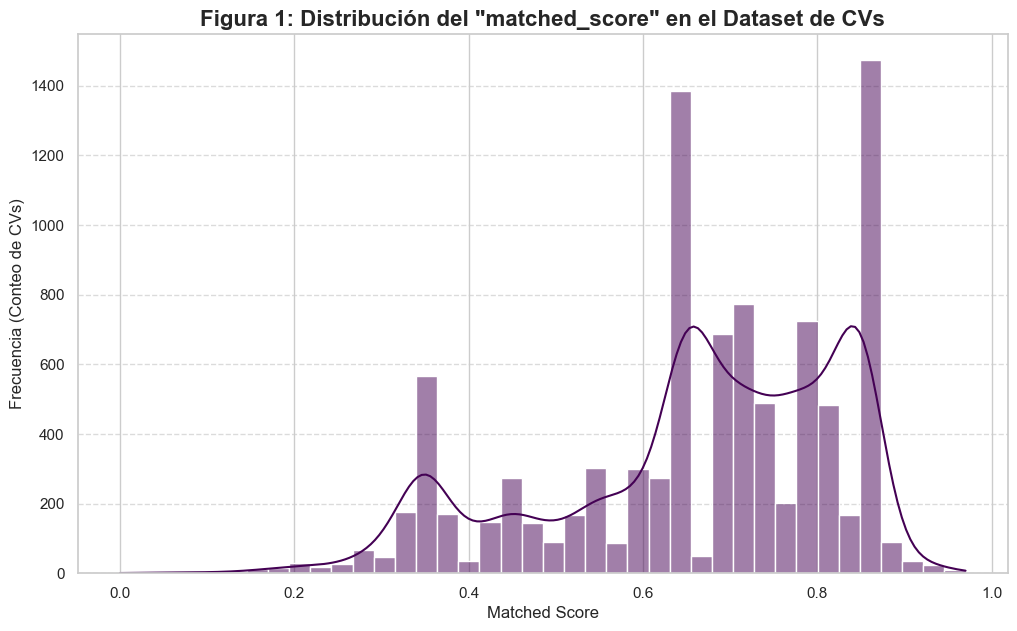

In [11]:
if 'cvs_df' in locals():
    plt.figure(figsize=(12, 7))
    sns.histplot(cvs_df['matched_score'], kde=True, bins=40, color="#440154")
    
    plt.title('Figura 1: Distribución del "matched_score" en el Dataset de CVs', fontsize=16, weight='bold')
    plt.xlabel('Matched Score', fontsize=12)
    plt.ylabel('Frecuencia (Conteo de CVs)', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Guardar la figura
    plt.savefig(os.path.join(output_dir, 'fig1_matched_score_dist.png'), dpi=300, bbox_inches='tight')
    
    plt.show()
else:
    print("DataFrame 'cvs_df' no encontrado. No se puede generar la Figura 1.")

C:\Users\zveng\AppData\Local\Temp\ipykernel_228924\2148251989.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=offers_processed_df, y='formatted_experience_level',


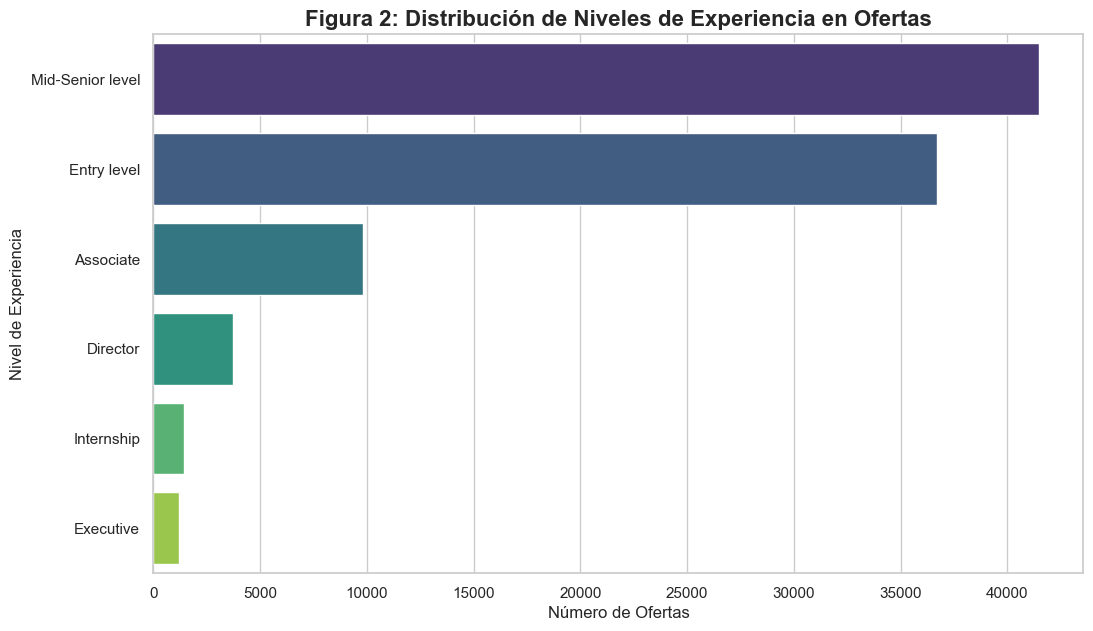

In [12]:
if 'offers_processed_df' in locals():
    plt.figure(figsize=(12, 7))
    
    # Usamos el countplot de seaborn, que cuenta las ocurrencias de cada categoría
    sns.countplot(data=offers_processed_df, y='formatted_experience_level', 
                  order=offers_processed_df['formatted_experience_level'].value_counts().index,
                  palette='viridis')
                  
    plt.title('Figura 2: Distribución de Niveles de Experiencia en Ofertas', fontsize=16, weight='bold')
    plt.xlabel('Número de Ofertas', fontsize=12)
    plt.ylabel('Nivel de Experiencia', fontsize=12)
    plt.xticks(rotation=0)
    
    # Guardar la figura
    plt.savefig(os.path.join(output_dir, 'fig2_experience_level_dist.png'), dpi=300, bbox_inches='tight')
    
    plt.show()
else:
    print("DataFrame 'offers_processed_df' no encontrado. No se puede generar la Figura 2.")

C:\Users\zveng\AppData\Local\Temp\ipykernel_228924\1791144981.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_15_offer_skills, x='Frecuencia en Ofertas', y='Habilidad', ax=axes[0], palette='viridis')
C:\Users\zveng\AppData\Local\Temp\ipykernel_228924\1791144981.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_15_cv_skills, x='Frecuencia en CVs', y='Habilidad', ax=axes[1], palette='plasma')


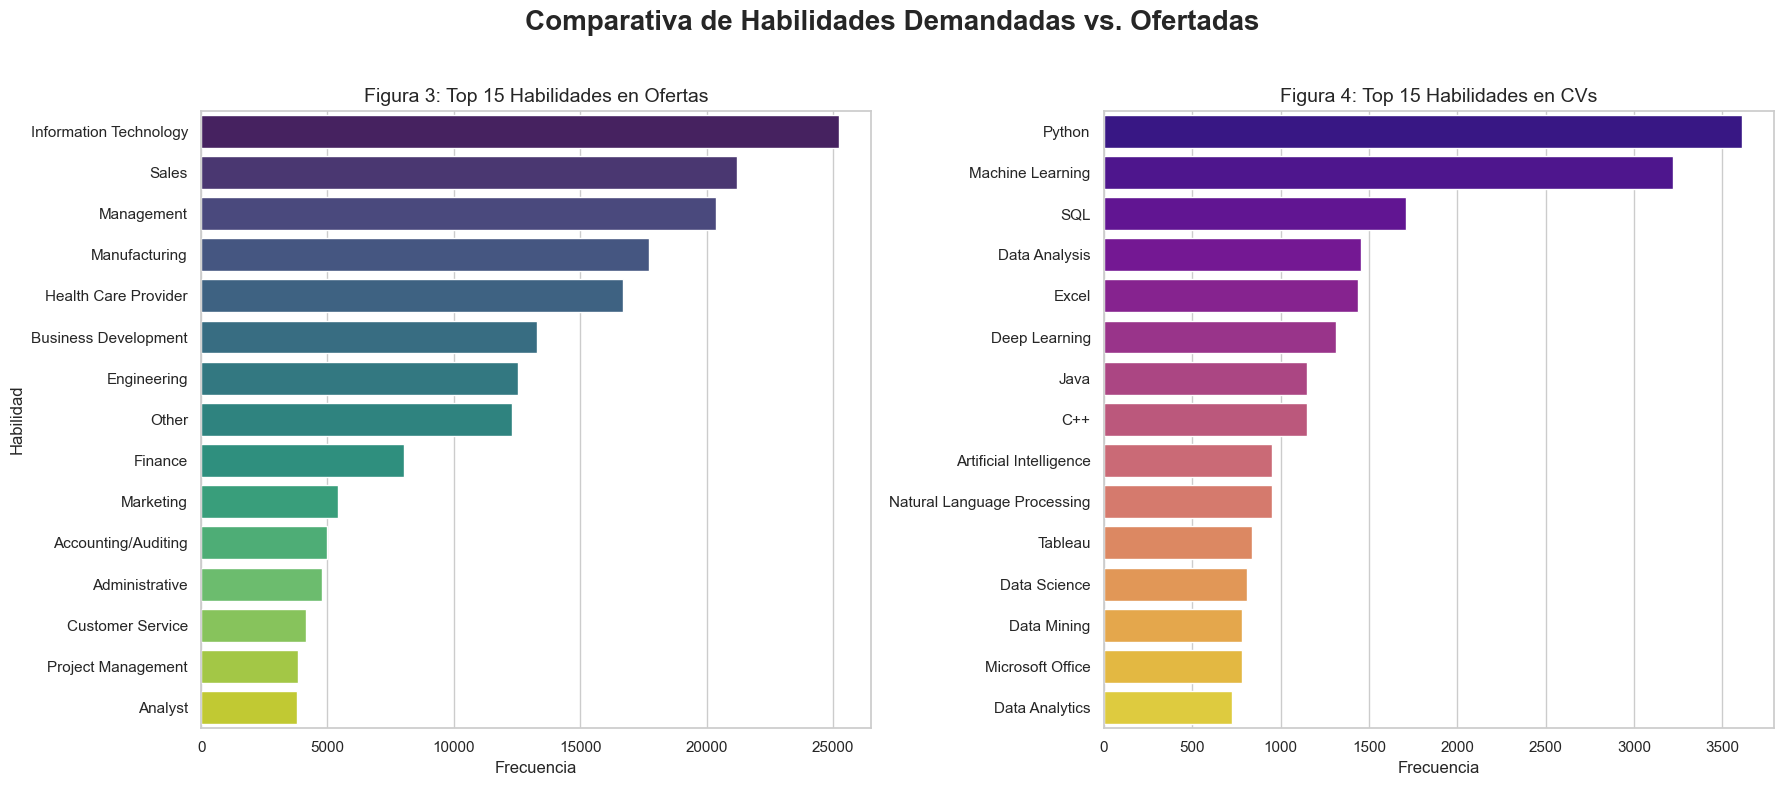

In [13]:
try:
    # Para Ofertas
    offer_skills = [skill for sublist in offers_processed_df['skills_list'] for skill in sublist]
    offer_skills_counts = Counter(offer_skills)
    top_15_offer_skills = pd.DataFrame(offer_skills_counts.most_common(15), columns=['Habilidad', 'Frecuencia en Ofertas'])

    # Para CVs
    cv_skills_raw = cvs_df['skills'].dropna().apply(parse_string_list)
    cv_skills = [skill for sublist in cv_skills_raw for skill in sublist]
    cv_skills_counts = Counter(cv_skills)
    top_15_cv_skills = pd.DataFrame(cv_skills_counts.most_common(15), columns=['Habilidad', 'Frecuencia en CVs'])

    # Creación de las figuras
    fig, axes = plt.subplots(1, 2, figsize=(18, 8)) # 1 fila, 2 columnas
    fig.suptitle('Comparativa de Habilidades Demandadas vs. Ofertadas', fontsize=20, weight='bold')

    # Gráfico 3: Top 15 Habilidades en Ofertas
    sns.barplot(data=top_15_offer_skills, x='Frecuencia en Ofertas', y='Habilidad', ax=axes[0], palette='viridis')
    axes[0].set_title('Figura 3: Top 15 Habilidades en Ofertas', fontsize=14)
    axes[0].set_xlabel('Frecuencia', fontsize=12)
    axes[0].set_ylabel('Habilidad', fontsize=12)

    # Gráfico 4: Top 15 Habilidades en CVs
    sns.barplot(data=top_15_cv_skills, x='Frecuencia en CVs', y='Habilidad', ax=axes[1], palette='plasma')
    axes[1].set_title('Figura 4: Top 15 Habilidades en CVs', fontsize=14)
    axes[1].set_xlabel('Frecuencia', fontsize=12)
    axes[1].set_ylabel('') 

    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Ajuste para que el supertítulo no se solape
    
    # Guardar la figura combinada
    plt.savefig(os.path.join(output_dir, 'fig3_4_skills_comparison.png'), dpi=300, bbox_inches='tight')
    
    plt.show()

except NameError:
    print("DataFrames no encontrados. No se pueden generar las Figuras 3 y 4.")